In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


In [3]:
cumulative_df = pd.read_csv("cumulative_data.csv", comment='#')

# Drop rows with missing values in key features
key_features = ['koi_steff', 'koi_slogg', 'koi_srad', 'koi_prad', 'koi_period', 'koi_score', 'koi_disposition']
cumulative_df.dropna(subset=key_features, inplace=True)

# Map disposition to binary labels
disposition_map = {
    'CONFIRMED': 1,
    'FALSE POSITIVE': 0,
    'CANDIDATE': 1  # You can change this to None if you want to ignore candidates
}
cumulative_df['label'] = cumulative_df['koi_disposition'].map(disposition_map)

# Final features and labels
features = ['koi_steff', 'koi_slogg', 'koi_srad', 'koi_prad', 'koi_period', 'koi_score']
X = cumulative_df[features].copy()
y = cumulative_df['label'].copy()

print(f"✅ Loaded {len(X)} samples")
print(y.value_counts())


✅ Loaded 7995 samples
label
1    4083
0    3912
Name: count, dtype: int64


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training shape: {X_train.shape}, Testing shape: {X_test.shape}")


Training shape: (6396, 6), Testing shape: (1599, 6)


In [6]:
tab_input = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(64, activation='relu')(tab_input)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu', name="tabular_embedding")(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

tabular_model = tf.keras.Model(inputs=tab_input, outputs=output)
tabular_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [7]:
history = tabular_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)
tabular_model.save_weights("tabular_model_weights.h5")



Epoch 1/20


160/160 [==============================] - 2s 4ms/step - loss: 0.2867 - accuracy: 0.9238 - val_loss: 0.0625 - val_accuracy: 0.9867
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0749 - accuracy: 0.9781 - val_loss: 0.0497 - val_accuracy: 0.9875
Epoch 3/20
160/160 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.9775 - val_loss: 0.0487 - val_accuracy: 0.9875
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0647 - accuracy: 0.9779 - val_loss: 0.0462 - val_accuracy: 0.9852
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0650 - accuracy: 0.9775 - val_loss: 0.0470 - val_accuracy: 0.9867
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9787 - val_loss: 0.0462 - val_accuracy: 0.9844
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0628 - accuracy: 0.9803 - val_loss: 0.0487 - val_accuracy: 0.9812


In [8]:
loss, accuracy = tabular_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed classification report
y_pred = (tabular_model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))


50/50 [==============================] - 0s 1ms/step - loss: 0.0615 - accuracy: 0.9819
Test Accuracy: 0.9819
50/50 [==============================] - 0s 997us/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       782
           1       0.99      0.97      0.98       817

    accuracy                           0.98      1599
   macro avg       0.98      0.98      0.98      1599
weighted avg       0.98      0.98      0.98      1599



50/50 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.9819
Test Accuracy: 0.9819
50/50 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       782
           1       0.99      0.97      0.98       817

    accuracy                           0.98      1599
   macro avg       0.98      0.98      0.98      1599
weighted avg       0.98      0.98      0.98      1599



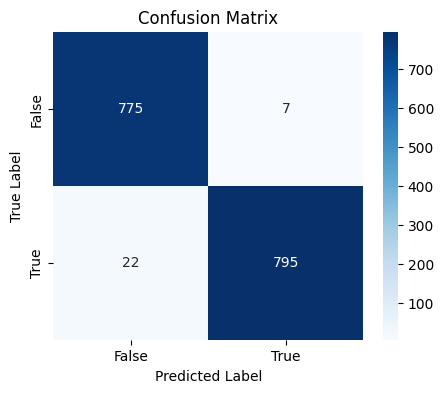

In [9]:
# 📦 Block 6: Evaluate the Model (Updated with Confusion Matrix)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate on test set
loss, accuracy = tabular_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
y_pred_probs = tabular_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


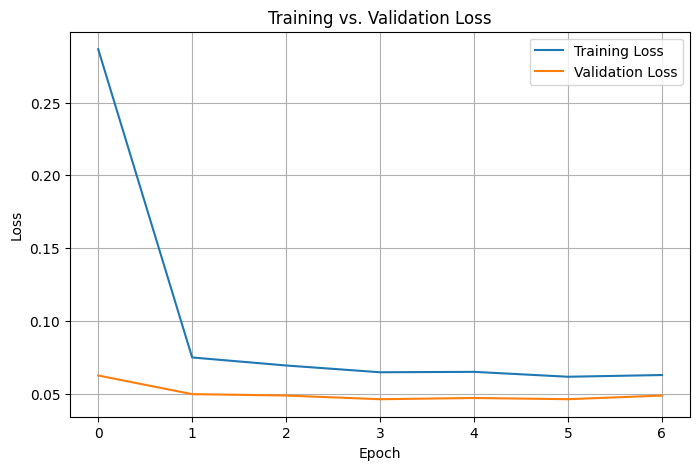

In [10]:
# 📈 Training vs Validation Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


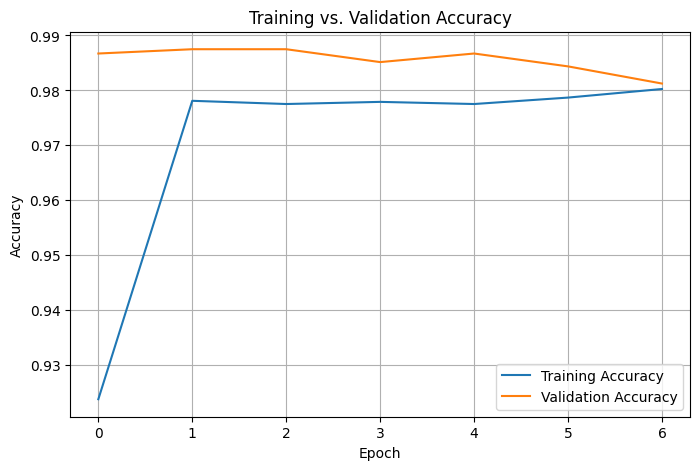

In [11]:
# 📈 Training vs Validation Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
